# Imports

In [1]:
import gdown
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import timm
import torch
import torch.nn.functional as F
import cv2

from collections import defaultdict
from PIL import Image, ImageOps
from tqdm import tqdm
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler, ConcatDataset, random_split
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Functions

In [2]:
# Plotar imagens aleatórias

def plot_random_images(dataset, gray=False):
    random_idx = np.random.randint(0, len(dataset), 9)

    plt.figure(figsize=(10, 10))
    for i, img_index in enumerate(random_idx):
        plt.subplot(3,3,i+1)
        plt.grid(False)
        image, label = dataset[img_index]
        plt.title(label)
        if gray:
          plt.imshow(image.permute(1,2,0), cmap='gray')
        else:
          plt.imshow(image.permute(1,2,0))
    
    plt.show()

In [3]:
# Plotar matriz de confusão

def plot_confusion_matrix_with_diagonal(
    cm,
    labels,
    title_matrix='Matriz de Confusão Normalizada',
    title_diagonal='Class Accuracies',
    extra_diagonals=None,
    extra_names=None
):

    row_sums = cm.sum(axis=1)

    sorted_indices = np.argsort(row_sums)[::-1]

    cm_sorted = cm[sorted_indices][:, sorted_indices]
    labels_sorted = [labels[i] for i in sorted_indices]

    cm_normalized = cm_sorted.astype('float') / cm_sorted.sum(axis=1)[:, np.newaxis]
    diagonal = np.diag(cm_normalized)

    accuracy_rows = [diagonal]
    accuracy_labels = [title_diagonal]

    if extra_diagonals is not None:
        accuracy_rows += extra_diagonals
    if extra_names is not None:
        accuracy_labels += extra_names
    elif extra_diagonals:
        accuracy_labels += [f'Modelo {i+1}' for i in range(len(extra_diagonals))]

    sns.set(font_scale=1.0)

    fig = plt.figure(figsize=(14, 16))

    ax1 = plt.subplot2grid((6, 1), (0, 0), rowspan=4)
    sns.heatmap(cm_normalized, annot=np.round(cm_normalized, 2), fmt=".2f", cmap='flare',
                xticklabels=labels_sorted, yticklabels=labels_sorted, linewidths=0.5,
                cbar=True, annot_kws={"size": 8}, ax=ax1)
    ax1.set_title(title_matrix)
    ax1.set_xlabel('Previsão')
    ax1.set_ylabel('Real')
    ax1.tick_params(axis='x', rotation=90)
    ax1.tick_params(axis='y', rotation=0)

    ax2 = plt.subplot2grid((6, 1), (4, 0), rowspan=2)
    sns.heatmap(accuracy_rows, annot=np.round(accuracy_rows, 2), fmt=".2f", cmap='flare',
                xticklabels=labels_sorted, yticklabels=accuracy_labels, cbar=True,
                linewidths=0.5, ax=ax2)
    ax2.tick_params(axis='x', rotation=90)
    ax2.tick_params(axis='y', rotation=0)

    plt.tight_layout()
    plt.show()


In [4]:
# Função auxiliar da train_classification()

def _train_step_classification(classifier_model, dataloader, criterion, optimizer, scheduler, device):
    classifier_model.train()

    total_loss = 0
    all_preds = []
    all_targets = []

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = classifier_model(X)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.size(0)

        y_pred_labels = torch.argmax(y_pred, axis=1)
        all_preds.extend(y_pred_labels.detach().cpu().numpy())
        all_targets.extend(y.detach().cpu().numpy())

    if scheduler:
        scheduler.step()

    mean_loss = total_loss / len(dataloader.dataset)
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='binary', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='binary', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='binary', zero_division=0)

    return mean_loss, accuracy, precision, recall, f1

In [5]:
# Função auxiliar da train_classification()

def _test_step_classification(classifier_model, dataloader, criterion, device):
    classifier_model.eval()

    total_loss = 0
    all_preds = []
    all_targets = []

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = classifier_model(X)
            loss = criterion(y_pred, y)

            total_loss += loss.item() * X.size(0)

            y_pred_labels = torch.argmax(y_pred, axis=1)
            all_preds.extend(y_pred_labels.detach().cpu().numpy())
            all_targets.extend(y.detach().cpu().numpy())

    mean_loss = total_loss / len(dataloader.dataset)
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='binary', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='binary', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='binary', zero_division=0)

    return mean_loss, accuracy, precision, recall, f1

In [6]:
# Treina rede de classificação

def train_classification(classifier_model, train_dataloader, test_dataloader, criterion, epochs, optimizers, schedulers, device='cpu', verbose=True):
    metrics = {'Train loss': [], 'Train accuracy': [], 'Train precision': [], 'Train recall': [], 'Train F1': [],
               'Test loss': [], 'Test accuracy': [], 'Test precision': [], 'Test recall': [], 'Test F1': []}

    current_optimizer_number = 0
    for optimizer, scheduler, num_epochs in zip(optimizers, schedulers, epochs):
        current_optimizer_number += 1
        for epoch in tqdm(range(1, num_epochs+1), desc=f'Training with optimizer {current_optimizer_number}'):
            current_lr = optimizer.param_groups[0]["lr"]
            train_loss, train_accuracy, train_precision, train_recall, train_f1= _train_step_classification(classifier_model, train_dataloader, criterion, optimizer, scheduler, device)
            test_loss, test_accuracy, test_precision, test_recall, test_f1 = _test_step_classification(classifier_model, test_dataloader, criterion, device)

            metrics['Train loss'].append(train_loss)
            metrics['Train accuracy'].append(train_accuracy)
            metrics['Train precision'].append(train_precision)
            metrics['Train recall'].append(train_recall)
            metrics['Train F1'].append(train_f1)
            metrics['Test loss'].append(test_loss)
            metrics['Test accuracy'].append(test_accuracy)
            metrics['Test precision'].append(test_precision)
            metrics['Test recall'].append(test_recall)
            metrics['Test F1'].append(test_f1)

            if verbose:
                print(f'\nEPOCH {epoch} | Current learning rate: {current_lr:.8f}\n'
                      f'Train loss: {train_loss:.4f} | Train accuracy: {train_accuracy:.4f} | Train precision: {train_precision:.4f} | Train recall: {train_recall:.4f} | Train F1: {train_f1:.4f}\n'
                      f'Test loss: {test_loss:.4f} | Test accuracy: {test_accuracy:.4f} | Test precision: {test_precision:.4f} | Test recall: {test_recall:.4f} | Test F1: {test_f1:.4f}\n')

    return metrics

In [7]:
# Retorna matriz de confusão

def get_conf_matrix(classifier_model, dataloader, device):
    classifier_model.eval()

    all_preds = []
    all_targets = []

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = classifier_model(X).argmax(dim=1).cpu()

            all_preds.extend(y_pred.cpu())
            all_targets.extend(y.cpu())

    conf_matrix = confusion_matrix(all_targets, all_preds)

    return conf_matrix

In [8]:
#Wrapper pra receber o subset do dataset e aplicar o transform

from torch.utils.data import Dataset

# Wrapper que aplica transform no subset
class TransformedDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset   # pode ser random_split (Subset)
        self.transform = transform

    def __getitem__(self, idx):
        x, y = self.subset[idx]   # retorna PIL Image + label
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

# Salt and pepper noise

In [9]:
# Classe customizada para o ruído Salt & Pepper
# Adaptada da sua função, para funcionar com a pipeline do PyTorch (PIL -> Numpy -> PIL)
class SaltPepperNoise:
    """
    Adiciona ruído 'sal e pimenta' a uma imagem.
    Recebe uma imagem PIL e retorna uma imagem PIL com ruído.
    """
    def __init__(self, salt_vs_pepper=0.5, amount=0.04):
        self.salt_vs_pepper = salt_vs_pepper
        self.amount = amount

    def __call__(self, img):
        # Converte PIL Image para Numpy Array (RGB)
        np_img = np.array(img)
        
        # Garante que a imagem seja colorida para o código funcionar
        if len(np_img.shape) != 3:
            return img # Retorna a imagem original se não for colorida

        # Copia a lógica da sua função original
        height, width, _ = np_img.shape
        num_salt = np.ceil(self.amount * (height * width) * self.salt_vs_pepper)
        num_pepper = np.ceil(self.amount * (height * width) * (1.0 - self.salt_vs_pepper))

        # Adiciona Sal (pontos brancos)
        coords_salt = [np.random.randint(0, i - 1, int(num_salt)) for i in np_img.shape[:2]]
        np_img[coords_salt[0], coords_salt[1], :] = [255, 255, 255]

        # Adiciona Pimenta (pontos pretos)
        coords_pepper = [np.random.randint(0, i - 1, int(num_pepper)) for i in np_img.shape[:2]]
        np_img[coords_pepper[0], coords_pepper[1], :] = [0, 0, 0]
        
        # Converte de volta para PIL Image
        return Image.fromarray(np_img)

# Dataset

In [10]:
"""
Salt and pepper e Gaussian Blur (Precisando ajustar melhor)

transform = transforms.Compose([
    # Redimensiona a imagem para o tamanho que a rede espera (substitui o CenterCrop).
    transforms.Resize((224, 224)),

    # Transformações geométricas iguais ao segundo código
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomAffine(degrees=30, translate=(0.00, 0.00), scale=(1.00, 1.00), shear=5),

    # Novas transformações aplicadas com uma certa probabilidade (comentadas por enquanto)
    # transforms.RandomApply([
    #     transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.0))
    # ], p=0.3),

    # transforms.RandomApply([
    #     SaltPepperNoise(amount=0.01)
    # ], p=0.3),

    # Transformação final
    transforms.ToTensor(),
])

# A transformação de teste também precisa ser ajustada
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
"""


'\nSalt and pepper e Gaussian Blur (Precisando ajustar melhor)\n\ntransform = transforms.Compose([\n    # Redimensiona a imagem para o tamanho que a rede espera (substitui o CenterCrop).\n    transforms.Resize((224, 224)),\n\n    # Transformações geométricas iguais ao segundo código\n    transforms.RandomHorizontalFlip(p=0.5),\n    transforms.RandomVerticalFlip(p=0.5),\n    transforms.RandomAffine(degrees=30, translate=(0.00, 0.00), scale=(1.00, 1.00), shear=5),\n\n    # Novas transformações aplicadas com uma certa probabilidade (comentadas por enquanto)\n    # transforms.RandomApply([\n    #     transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.0))\n    # ], p=0.3),\n\n    # transforms.RandomApply([\n    #     SaltPepperNoise(amount=0.01)\n    # ], p=0.3),\n\n    # Transformação final\n    transforms.ToTensor(),\n])\n\n# A transformação de teste também precisa ser ajustada\ntest_transform = transforms.Compose([\n    transforms.Resize((224, 224)),\n    transforms.ToTensor(),\n]

In [11]:
train_transform = transforms.Compose([
    transforms.CenterCrop(224),              
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),        
    transforms.RandomAffine(degrees=30, translate=(0.00, 0.00), scale=(1.00, 1.00), shear=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.CenterCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [12]:
fold_0 = ImageFolder("/kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (PKG)/C-NMC_training_data/fold_0")
fold_1 = ImageFolder("/kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (PKG)/C-NMC_training_data/fold_1")
fold_2 = ImageFolder("/kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (PKG)/C-NMC_training_data/fold_2")

dataset = ConcatDataset([fold_0, fold_1, fold_2])

In [13]:
seed = 42
g = torch.Generator().manual_seed(seed)

# Tamanhos
n_total = len(dataset)
n_test = int(0.10 * n_total)
n_val  = int(0.20 * n_total)
n_train = n_total - n_val - n_test

# Split
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [n_train, n_val, n_test], generator=g
)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

Train: 7463 | Val: 2132 | Test: 1066


In [14]:
train_dataset = TransformedDataset(train_dataset, transform=train_transform)
val_dataset   = TransformedDataset(val_dataset,   transform=val_transform)
test_dataset  = TransformedDataset(test_dataset,  transform=test_transform)

In [15]:
# Conta quantos exemplos existem de cada classe
targets = [y for _, y in train_dataset]  # pode ser custoso se dataset for grande

class_sample_counts = np.bincount(targets)  # [num_classe0, num_classe1]
weights = 1. / class_sample_counts          # inverso da frequência

# Cria vetor de pesos para cada exemplo
sample_weights = [weights[t] for t in targets]

# Sampler balanceado
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=30000,   # total de amostras desejadas
    replacement=True     # permite repetir para balancear
)

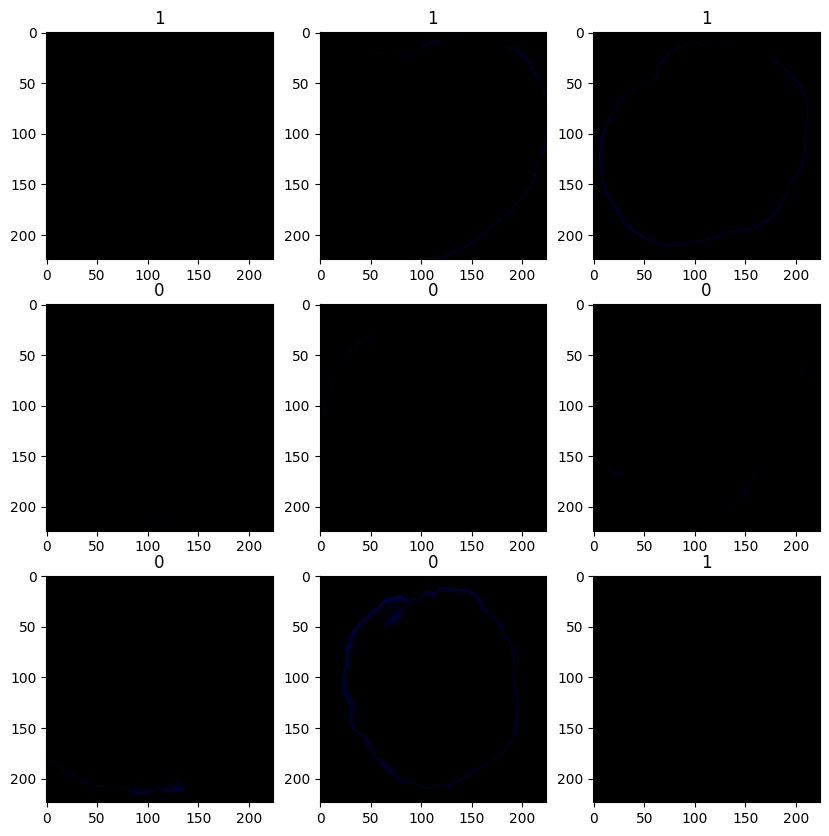

In [16]:
plot_random_images(train_dataset)

# Model

In [17]:
class SwinTransformerBase(nn.Module):
    def __init__(self, drop_path_rate=0, drop_rate=0, attn_drop_rate=0):
        super().__init__()
        self.model = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=True,
            num_classes=2,
            drop_path_rate=drop_path_rate,
            drop_rate=drop_rate,
            attn_drop_rate=attn_drop_rate
        )


    def forward(self, x):
        return self.model(x)

# Training

In [18]:
# Dispositivo (CPU ou GPU)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [19]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)

## Classification

In [20]:
from torch.optim.lr_scheduler import CosineAnnealingLR

classifier_model = SwinTransformerBase(drop_path_rate=0.15, drop_rate=0.2, attn_drop_rate=0.0).to(device)
criterion = nn.CrossEntropyLoss().to(device)

optimizer = optim.AdamW(classifier_model.parameters(), lr=1e-4, weight_decay=5e-2) 


scheduler = optim.lr_scheduler.StepLR(optimizer, 1, 0.9)

optimizers = [optimizer]
schedulers = [scheduler]
epochs = [50]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [21]:
"""# Hiperparâmetros que você quer testar
lrs = [1e-3, 1e-4]
weight_decays = [1e-2, 1e-4]
drop_path_rates = [0.1, 0.2]
drop_rates = [0.0, 0.1]

criterion = nn.CrossEntropyLoss().to(device)

results = []

for lr in lrs:
    for wd in weight_decays:
        for dpr in drop_path_rates:
            for dr in drop_rates:
                print(f"\n=== Treinando com lr={lr}, wd={wd}, drop_path={dpr}, drop_rate={dr} ===")

                # Modelo com drops variáveis
                classifier_model = SwinTransformerTiny(
                    drop_path_rate=dpr,
                    drop_rate=dr,
                    attn_drop_rate=0.0
                ).to(device)

                optimizer = optim.AdamW(classifier_model.parameters(), lr=lr, weight_decay=wd)
                scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

                metrics = train_classification(
                    classifier_model,
                    train_dataloader,
                    val_dataloader,
                    criterion,
                    epochs=[5],               # 10 épocas fixas
                    optimizers=[optimizer],
                    schedulers=[scheduler],
                    device=device,
                    verbose=False              # deixa False pra não poluir a saída
                )

                results.append(((lr, wd, dpr, dr), metrics))"""


'# Hiperparâmetros que você quer testar\nlrs = [1e-3, 1e-4]\nweight_decays = [1e-2, 1e-4]\ndrop_path_rates = [0.1, 0.2]\ndrop_rates = [0.0, 0.1]\n\ncriterion = nn.CrossEntropyLoss().to(device)\n\nresults = []\n\nfor lr in lrs:\n    for wd in weight_decays:\n        for dpr in drop_path_rates:\n            for dr in drop_rates:\n                print(f"\n=== Treinando com lr={lr}, wd={wd}, drop_path={dpr}, drop_rate={dr} ===")\n\n                # Modelo com drops variáveis\n                classifier_model = SwinTransformerTiny(\n                    drop_path_rate=dpr,\n                    drop_rate=dr,\n                    attn_drop_rate=0.0\n                ).to(device)\n\n                optimizer = optim.AdamW(classifier_model.parameters(), lr=lr, weight_decay=wd)\n                scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)\n\n                metrics = train_classification(\n                    classifier_model,\n                    train_dataloader,\n 

In [22]:
"""import matplotlib.pyplot as plt

def plot_results(results):
    metrics_names = [
        ("Train loss", "Test loss"),
        ("Train accuracy", "Test accuracy"),
        ("Train precision", "Test precision"),
        ("Train recall", "Test recall"),
        ("Train F1", "Test F1"),
    ]

    for (lr, wd, dpr, dr), metrics in results:
        fig, axs = plt.subplots(1, len(metrics_names), figsize=(25, 4))

        fig.suptitle(f"lr={lr}, wd={wd}, drop_path={dpr}, drop_rate={dr}", fontsize=14)

        for ax, (train_key, test_key) in zip(axs, metrics_names):
            ax.plot(metrics[train_key], label="Train")
            ax.plot(metrics[test_key], label="Test")
            ax.set_title(train_key.replace("Train ", ""))
            ax.set_xlabel("Epoch")
            ax.legend()

        plt.show()"""


'import matplotlib.pyplot as plt\n\ndef plot_results(results):\n    metrics_names = [\n        ("Train loss", "Test loss"),\n        ("Train accuracy", "Test accuracy"),\n        ("Train precision", "Test precision"),\n        ("Train recall", "Test recall"),\n        ("Train F1", "Test F1"),\n    ]\n\n    for (lr, wd, dpr, dr), metrics in results:\n        fig, axs = plt.subplots(1, len(metrics_names), figsize=(25, 4))\n\n        fig.suptitle(f"lr={lr}, wd={wd}, drop_path={dpr}, drop_rate={dr}", fontsize=14)\n\n        for ax, (train_key, test_key) in zip(axs, metrics_names):\n            ax.plot(metrics[train_key], label="Train")\n            ax.plot(metrics[test_key], label="Test")\n            ax.set_title(train_key.replace("Train ", ""))\n            ax.set_xlabel("Epoch")\n            ax.legend()\n\n        plt.show()'

In [23]:
#plot_results(results)

In [24]:
# Baixando parâmetros do drive (se necessário)
#gdown.download('https://drive.google.com/file/d/1xowiBw8I_GhCwx2sTwM7ttyqrGkawpc7/view?usp=drive_link', 'parameters.pth', fuzzy=True, quiet=False)

In [25]:
# Carregando parâmetros
#classifier_model.load_state_dict(torch.load('/kaggle/working/parameters.pth'))

In [26]:
# Treino
metrics = train_classification(classifier_model, train_dataloader, val_dataloader, criterion, epochs, optimizers, schedulers, device)

Training with optimizer 1:   2%|▏         | 1/50 [02:41<2:11:48, 161.40s/it]


EPOCH 1 | Current learning rate: 0.00010000
Train loss: 0.4732 | Train accuracy: 0.7890 | Train precision: 0.7455 | Train recall: 0.5174 | Train F1: 0.6108
Test loss: 0.2954 | Test accuracy: 0.8921 | Test precision: 0.9457 | Test recall: 0.6895 | Test F1: 0.7975



Training with optimizer 1:   4%|▍         | 2/50 [05:20<2:08:14, 160.30s/it]


EPOCH 2 | Current learning rate: 0.00009000
Train loss: 0.3082 | Train accuracy: 0.8735 | Train precision: 0.8699 | Train recall: 0.7112 | Train F1: 0.7826
Test loss: 0.2292 | Test accuracy: 0.9193 | Test precision: 0.9840 | Test recall: 0.7504 | Test F1: 0.8515



Training with optimizer 1:   6%|▌         | 3/50 [08:00<2:05:15, 159.91s/it]


EPOCH 3 | Current learning rate: 0.00008100
Train loss: 0.2143 | Train accuracy: 0.9189 | Train precision: 0.9318 | Train recall: 0.8058 | Train F1: 0.8642
Test loss: 0.1411 | Test accuracy: 0.9437 | Test precision: 0.9891 | Test recall: 0.8265 | Test F1: 0.9005



Training with optimizer 1:   8%|▊         | 4/50 [10:39<2:02:27, 159.73s/it]


EPOCH 4 | Current learning rate: 0.00007290
Train loss: 0.1867 | Train accuracy: 0.9329 | Train precision: 0.9407 | Train recall: 0.8434 | Train F1: 0.8894
Test loss: 0.1230 | Test accuracy: 0.9606 | Test precision: 0.9540 | Test recall: 0.9163 | Test F1: 0.9348



Training with optimizer 1:  10%|█         | 5/50 [13:19<1:59:44, 159.65s/it]


EPOCH 5 | Current learning rate: 0.00006561
Train loss: 0.1495 | Train accuracy: 0.9484 | Train precision: 0.9501 | Train recall: 0.8853 | Train F1: 0.9166
Test loss: 0.1407 | Test accuracy: 0.9550 | Test precision: 0.9095 | Test recall: 0.9482 | Test F1: 0.9285



Training with optimizer 1:  12%|█▏        | 6/50 [15:58<1:57:02, 159.61s/it]


EPOCH 6 | Current learning rate: 0.00005905
Train loss: 0.1229 | Train accuracy: 0.9560 | Train precision: 0.9586 | Train recall: 0.9016 | Train F1: 0.9292
Test loss: 0.2403 | Test accuracy: 0.9076 | Test precision: 0.7861 | Test recall: 0.9619 | Test F1: 0.8652



Training with optimizer 1:  14%|█▍        | 7/50 [18:38<1:54:25, 159.66s/it]


EPOCH 7 | Current learning rate: 0.00005314
Train loss: 0.1032 | Train accuracy: 0.9644 | Train precision: 0.9658 | Train recall: 0.9213 | Train F1: 0.9430
Test loss: 0.1112 | Test accuracy: 0.9597 | Test precision: 0.9156 | Test recall: 0.9574 | Test F1: 0.9360



Training with optimizer 1:  16%|█▌        | 8/50 [21:18<1:51:43, 159.62s/it]


EPOCH 8 | Current learning rate: 0.00004783
Train loss: 0.0945 | Train accuracy: 0.9660 | Train precision: 0.9647 | Train recall: 0.9276 | Train F1: 0.9458
Test loss: 0.1254 | Test accuracy: 0.9470 | Test precision: 0.8726 | Test recall: 0.9696 | Test F1: 0.9185



Training with optimizer 1:  18%|█▊        | 9/50 [23:57<1:49:02, 159.57s/it]


EPOCH 9 | Current learning rate: 0.00004305
Train loss: 0.0719 | Train accuracy: 0.9744 | Train precision: 0.9729 | Train recall: 0.9464 | Train F1: 0.9595
Test loss: 0.0656 | Test accuracy: 0.9775 | Test precision: 0.9780 | Test recall: 0.9482 | Test F1: 0.9629



Training with optimizer 1:  20%|██        | 10/50 [26:37<1:46:21, 159.53s/it]


EPOCH 10 | Current learning rate: 0.00003874
Train loss: 0.0650 | Train accuracy: 0.9774 | Train precision: 0.9752 | Train recall: 0.9535 | Train F1: 0.9642
Test loss: 0.0961 | Test accuracy: 0.9658 | Test precision: 0.9520 | Test recall: 0.9361 | Test F1: 0.9440



Training with optimizer 1:  22%|██▏       | 11/50 [29:16<1:43:40, 159.51s/it]


EPOCH 11 | Current learning rate: 0.00003487
Train loss: 0.0487 | Train accuracy: 0.9835 | Train precision: 0.9809 | Train recall: 0.9674 | Train F1: 0.9741
Test loss: 0.0732 | Test accuracy: 0.9770 | Test precision: 0.9634 | Test recall: 0.9619 | Test F1: 0.9627



Training with optimizer 1:  24%|██▍       | 12/50 [31:56<1:41:01, 159.51s/it]


EPOCH 12 | Current learning rate: 0.00003138
Train loss: 0.0460 | Train accuracy: 0.9850 | Train precision: 0.9818 | Train recall: 0.9711 | Train F1: 0.9764
Test loss: 0.0525 | Test accuracy: 0.9841 | Test precision: 0.9921 | Test recall: 0.9559 | Test F1: 0.9736



Training with optimizer 1:  26%|██▌       | 13/50 [34:35<1:38:21, 159.50s/it]


EPOCH 13 | Current learning rate: 0.00002824
Train loss: 0.0319 | Train accuracy: 0.9897 | Train precision: 0.9919 | Train recall: 0.9757 | Train F1: 0.9838
Test loss: 0.0807 | Test accuracy: 0.9775 | Test precision: 0.9872 | Test recall: 0.9391 | Test F1: 0.9626



Training with optimizer 1:  28%|██▊       | 14/50 [37:15<1:35:42, 159.50s/it]


EPOCH 14 | Current learning rate: 0.00002542
Train loss: 0.0259 | Train accuracy: 0.9906 | Train precision: 0.9890 | Train recall: 0.9816 | Train F1: 0.9853
Test loss: 0.0743 | Test accuracy: 0.9812 | Test precision: 0.9858 | Test recall: 0.9528 | Test F1: 0.9690



Training with optimizer 1:  30%|███       | 15/50 [39:54<1:33:04, 159.54s/it]


EPOCH 15 | Current learning rate: 0.00002288
Train loss: 0.0230 | Train accuracy: 0.9918 | Train precision: 0.9911 | Train recall: 0.9833 | Train F1: 0.9872
Test loss: 0.0797 | Test accuracy: 0.9789 | Test precision: 0.9968 | Test recall: 0.9346 | Test F1: 0.9647



Training with optimizer 1:  32%|███▏      | 16/50 [42:34<1:30:24, 159.55s/it]


EPOCH 16 | Current learning rate: 0.00002059
Train loss: 0.0210 | Train accuracy: 0.9938 | Train precision: 0.9933 | Train recall: 0.9874 | Train F1: 0.9903
Test loss: 0.0626 | Test accuracy: 0.9855 | Test precision: 0.9968 | Test recall: 0.9559 | Test F1: 0.9759



Training with optimizer 1:  34%|███▍      | 17/50 [45:13<1:27:44, 159.54s/it]


EPOCH 17 | Current learning rate: 0.00001853
Train loss: 0.0120 | Train accuracy: 0.9957 | Train precision: 0.9950 | Train recall: 0.9916 | Train F1: 0.9933
Test loss: 0.0515 | Test accuracy: 0.9873 | Test precision: 0.9891 | Test recall: 0.9696 | Test F1: 0.9792



Training with optimizer 1:  36%|███▌      | 18/50 [47:53<1:25:04, 159.52s/it]


EPOCH 18 | Current learning rate: 0.00001668
Train loss: 0.0088 | Train accuracy: 0.9969 | Train precision: 0.9958 | Train recall: 0.9946 | Train F1: 0.9952
Test loss: 0.0963 | Test accuracy: 0.9841 | Test precision: 0.9890 | Test recall: 0.9589 | Test F1: 0.9737



Training with optimizer 1:  38%|███▊      | 19/50 [50:32<1:22:25, 159.52s/it]


EPOCH 19 | Current learning rate: 0.00001501
Train loss: 0.0137 | Train accuracy: 0.9946 | Train precision: 0.9933 | Train recall: 0.9900 | Train F1: 0.9916
Test loss: 0.0997 | Test accuracy: 0.9808 | Test precision: 0.9920 | Test recall: 0.9452 | Test F1: 0.9680



Training with optimizer 1:  40%|████      | 20/50 [53:12<1:19:45, 159.53s/it]


EPOCH 20 | Current learning rate: 0.00001351
Train loss: 0.0113 | Train accuracy: 0.9967 | Train precision: 0.9975 | Train recall: 0.9920 | Train F1: 0.9948
Test loss: 0.0696 | Test accuracy: 0.9822 | Test precision: 0.9682 | Test recall: 0.9741 | Test F1: 0.9712



Training with optimizer 1:  42%|████▏     | 21/50 [55:51<1:17:05, 159.52s/it]


EPOCH 21 | Current learning rate: 0.00001216
Train loss: 0.0081 | Train accuracy: 0.9975 | Train precision: 0.9962 | Train recall: 0.9958 | Train F1: 0.9960
Test loss: 0.0696 | Test accuracy: 0.9869 | Test precision: 0.9937 | Test recall: 0.9635 | Test F1: 0.9784



Training with optimizer 1:  44%|████▍     | 22/50 [58:31<1:14:26, 159.50s/it]


EPOCH 22 | Current learning rate: 0.00001094
Train loss: 0.0071 | Train accuracy: 0.9977 | Train precision: 0.9971 | Train recall: 0.9958 | Train F1: 0.9964
Test loss: 0.0661 | Test accuracy: 0.9859 | Test precision: 0.9831 | Test recall: 0.9711 | Test F1: 0.9770



Training with optimizer 1:  46%|████▌     | 23/50 [1:01:10<1:11:46, 159.51s/it]


EPOCH 23 | Current learning rate: 0.00000985
Train loss: 0.0036 | Train accuracy: 0.9991 | Train precision: 0.9987 | Train recall: 0.9983 | Train F1: 0.9985
Test loss: 0.0737 | Test accuracy: 0.9831 | Test precision: 0.9697 | Test recall: 0.9756 | Test F1: 0.9727



Training with optimizer 1:  48%|████▊     | 24/50 [1:03:50<1:09:08, 159.57s/it]


EPOCH 24 | Current learning rate: 0.00000886
Train loss: 0.0055 | Train accuracy: 0.9983 | Train precision: 0.9975 | Train recall: 0.9971 | Train F1: 0.9973
Test loss: 0.0587 | Test accuracy: 0.9831 | Test precision: 0.9755 | Test recall: 0.9696 | Test F1: 0.9725



Training with optimizer 1:  50%|█████     | 25/50 [1:06:29<1:06:28, 159.55s/it]


EPOCH 25 | Current learning rate: 0.00000798
Train loss: 0.0047 | Train accuracy: 0.9985 | Train precision: 0.9979 | Train recall: 0.9975 | Train F1: 0.9977
Test loss: 0.0686 | Test accuracy: 0.9869 | Test precision: 0.9953 | Test recall: 0.9619 | Test F1: 0.9783



Training with optimizer 1:  52%|█████▏    | 26/50 [1:09:09<1:03:48, 159.54s/it]


EPOCH 26 | Current learning rate: 0.00000718
Train loss: 0.0033 | Train accuracy: 0.9987 | Train precision: 0.9983 | Train recall: 0.9975 | Train F1: 0.9979
Test loss: 0.0744 | Test accuracy: 0.9869 | Test precision: 0.9906 | Test recall: 0.9665 | Test F1: 0.9784



Training with optimizer 1:  54%|█████▍    | 27/50 [1:11:49<1:01:09, 159.54s/it]


EPOCH 27 | Current learning rate: 0.00000646
Train loss: 0.0039 | Train accuracy: 0.9992 | Train precision: 0.9987 | Train recall: 0.9987 | Train F1: 0.9987
Test loss: 0.0696 | Test accuracy: 0.9869 | Test precision: 0.9802 | Test recall: 0.9772 | Test F1: 0.9787



Training with optimizer 1:  56%|█████▌    | 28/50 [1:14:28<58:29, 159.51s/it]  


EPOCH 28 | Current learning rate: 0.00000581
Train loss: 0.0049 | Train accuracy: 0.9981 | Train precision: 0.9971 | Train recall: 0.9971 | Train F1: 0.9971
Test loss: 0.0726 | Test accuracy: 0.9883 | Test precision: 0.9877 | Test recall: 0.9741 | Test F1: 0.9808



Training with optimizer 1:  58%|█████▊    | 29/50 [1:17:07<55:49, 159.50s/it]


EPOCH 29 | Current learning rate: 0.00000523
Train loss: 0.0025 | Train accuracy: 0.9992 | Train precision: 0.9987 | Train recall: 0.9987 | Train F1: 0.9987
Test loss: 0.0811 | Test accuracy: 0.9869 | Test precision: 0.9876 | Test recall: 0.9696 | Test F1: 0.9785



Training with optimizer 1:  60%|██████    | 30/50 [1:19:47<53:09, 159.47s/it]


EPOCH 30 | Current learning rate: 0.00000471
Train loss: 0.0030 | Train accuracy: 0.9991 | Train precision: 0.9992 | Train recall: 0.9979 | Train F1: 0.9985
Test loss: 0.0746 | Test accuracy: 0.9883 | Test precision: 0.9847 | Test recall: 0.9772 | Test F1: 0.9809



Training with optimizer 1:  62%|██████▏   | 31/50 [1:22:26<50:29, 159.46s/it]


EPOCH 31 | Current learning rate: 0.00000424
Train loss: 0.0041 | Train accuracy: 0.9989 | Train precision: 0.9979 | Train recall: 0.9987 | Train F1: 0.9983
Test loss: 0.0701 | Test accuracy: 0.9902 | Test precision: 0.9907 | Test recall: 0.9772 | Test F1: 0.9839



Training with optimizer 1:  64%|██████▍   | 32/50 [1:25:06<47:50, 159.49s/it]


EPOCH 32 | Current learning rate: 0.00000382
Train loss: 0.0016 | Train accuracy: 0.9995 | Train precision: 0.9987 | Train recall: 0.9996 | Train F1: 0.9992
Test loss: 0.0671 | Test accuracy: 0.9892 | Test precision: 0.9922 | Test recall: 0.9726 | Test F1: 0.9823



Training with optimizer 1:  66%|██████▌   | 33/50 [1:27:45<45:11, 159.49s/it]


EPOCH 33 | Current learning rate: 0.00000343
Train loss: 0.0028 | Train accuracy: 0.9988 | Train precision: 0.9983 | Train recall: 0.9979 | Train F1: 0.9981
Test loss: 0.0758 | Test accuracy: 0.9878 | Test precision: 0.9891 | Test recall: 0.9711 | Test F1: 0.9800



Training with optimizer 1:  68%|██████▊   | 34/50 [1:30:25<42:31, 159.48s/it]


EPOCH 34 | Current learning rate: 0.00000309
Train loss: 0.0019 | Train accuracy: 0.9999 | Train precision: 1.0000 | Train recall: 0.9996 | Train F1: 0.9998
Test loss: 0.0709 | Test accuracy: 0.9883 | Test precision: 0.9862 | Test recall: 0.9756 | Test F1: 0.9809



Training with optimizer 1:  70%|███████   | 35/50 [1:33:04<39:51, 159.44s/it]


EPOCH 35 | Current learning rate: 0.00000278
Train loss: 0.0028 | Train accuracy: 0.9987 | Train precision: 0.9975 | Train recall: 0.9983 | Train F1: 0.9979
Test loss: 0.0859 | Test accuracy: 0.9878 | Test precision: 0.9937 | Test recall: 0.9665 | Test F1: 0.9799



Training with optimizer 1:  72%|███████▏  | 36/50 [1:35:44<37:11, 159.42s/it]


EPOCH 36 | Current learning rate: 0.00000250
Train loss: 0.0016 | Train accuracy: 0.9995 | Train precision: 0.9996 | Train recall: 0.9987 | Train F1: 0.9992
Test loss: 0.0767 | Test accuracy: 0.9869 | Test precision: 0.9861 | Test recall: 0.9711 | Test F1: 0.9785



Training with optimizer 1:  74%|███████▍  | 37/50 [1:38:23<34:32, 159.41s/it]


EPOCH 37 | Current learning rate: 0.00000225
Train loss: 0.0018 | Train accuracy: 0.9997 | Train precision: 0.9996 | Train recall: 0.9996 | Train F1: 0.9996
Test loss: 0.0754 | Test accuracy: 0.9892 | Test precision: 0.9969 | Test recall: 0.9680 | Test F1: 0.9822



Training with optimizer 1:  76%|███████▌  | 38/50 [1:41:02<31:53, 159.43s/it]


EPOCH 38 | Current learning rate: 0.00000203
Train loss: 0.0012 | Train accuracy: 0.9995 | Train precision: 0.9996 | Train recall: 0.9987 | Train F1: 0.9992
Test loss: 0.0736 | Test accuracy: 0.9864 | Test precision: 0.9801 | Test recall: 0.9756 | Test F1: 0.9779



Training with optimizer 1:  78%|███████▊  | 39/50 [1:43:42<29:14, 159.46s/it]


EPOCH 39 | Current learning rate: 0.00000182
Train loss: 0.0004 | Train accuracy: 0.9999 | Train precision: 0.9996 | Train recall: 1.0000 | Train F1: 0.9998
Test loss: 0.0743 | Test accuracy: 0.9892 | Test precision: 0.9938 | Test recall: 0.9711 | Test F1: 0.9823



Training with optimizer 1:  80%|████████  | 40/50 [1:46:21<26:34, 159.47s/it]


EPOCH 40 | Current learning rate: 0.00000164
Train loss: 0.0020 | Train accuracy: 0.9993 | Train precision: 0.9992 | Train recall: 0.9987 | Train F1: 0.9990
Test loss: 0.0764 | Test accuracy: 0.9902 | Test precision: 0.9969 | Test recall: 0.9711 | Test F1: 0.9838



Training with optimizer 1:  82%|████████▏ | 41/50 [1:49:01<23:55, 159.49s/it]


EPOCH 41 | Current learning rate: 0.00000148
Train loss: 0.0027 | Train accuracy: 0.9993 | Train precision: 0.9992 | Train recall: 0.9987 | Train F1: 0.9990
Test loss: 0.0696 | Test accuracy: 0.9887 | Test precision: 0.9877 | Test recall: 0.9756 | Test F1: 0.9816



Training with optimizer 1:  84%|████████▍ | 42/50 [1:51:41<21:16, 159.52s/it]


EPOCH 42 | Current learning rate: 0.00000133
Train loss: 0.0007 | Train accuracy: 0.9997 | Train precision: 0.9996 | Train recall: 0.9996 | Train F1: 0.9996
Test loss: 0.0727 | Test accuracy: 0.9897 | Test precision: 0.9938 | Test recall: 0.9726 | Test F1: 0.9831



Training with optimizer 1:  86%|████████▌ | 43/50 [1:54:20<18:36, 159.51s/it]


EPOCH 43 | Current learning rate: 0.00000120
Train loss: 0.0011 | Train accuracy: 0.9996 | Train precision: 0.9992 | Train recall: 0.9996 | Train F1: 0.9994
Test loss: 0.0708 | Test accuracy: 0.9887 | Test precision: 0.9922 | Test recall: 0.9711 | Test F1: 0.9815



Training with optimizer 1:  88%|████████▊ | 44/50 [1:57:00<15:57, 159.50s/it]


EPOCH 44 | Current learning rate: 0.00000108
Train loss: 0.0022 | Train accuracy: 0.9991 | Train precision: 0.9992 | Train recall: 0.9979 | Train F1: 0.9985
Test loss: 0.0694 | Test accuracy: 0.9892 | Test precision: 0.9877 | Test recall: 0.9772 | Test F1: 0.9824



Training with optimizer 1:  90%|█████████ | 45/50 [1:59:39<13:17, 159.49s/it]


EPOCH 45 | Current learning rate: 0.00000097
Train loss: 0.0013 | Train accuracy: 0.9995 | Train precision: 0.9992 | Train recall: 0.9992 | Train F1: 0.9992
Test loss: 0.0693 | Test accuracy: 0.9897 | Test precision: 0.9922 | Test recall: 0.9741 | Test F1: 0.9831



Training with optimizer 1:  92%|█████████▏| 46/50 [2:02:18<10:37, 159.46s/it]


EPOCH 46 | Current learning rate: 0.00000087
Train loss: 0.0010 | Train accuracy: 0.9997 | Train precision: 0.9996 | Train recall: 0.9996 | Train F1: 0.9996
Test loss: 0.0717 | Test accuracy: 0.9902 | Test precision: 0.9953 | Test recall: 0.9726 | Test F1: 0.9838



Training with optimizer 1:  94%|█████████▍| 47/50 [2:04:58<07:58, 159.49s/it]


EPOCH 47 | Current learning rate: 0.00000079
Train loss: 0.0007 | Train accuracy: 0.9999 | Train precision: 0.9996 | Train recall: 1.0000 | Train F1: 0.9998
Test loss: 0.0734 | Test accuracy: 0.9897 | Test precision: 0.9953 | Test recall: 0.9711 | Test F1: 0.9831



Training with optimizer 1:  96%|█████████▌| 48/50 [2:07:37<05:18, 159.46s/it]


EPOCH 48 | Current learning rate: 0.00000071
Train loss: 0.0006 | Train accuracy: 0.9999 | Train precision: 1.0000 | Train recall: 0.9996 | Train F1: 0.9998
Test loss: 0.0720 | Test accuracy: 0.9902 | Test precision: 0.9953 | Test recall: 0.9726 | Test F1: 0.9838



Training with optimizer 1:  98%|█████████▊| 49/50 [2:10:17<02:39, 159.44s/it]


EPOCH 49 | Current learning rate: 0.00000064
Train loss: 0.0020 | Train accuracy: 0.9993 | Train precision: 0.9992 | Train recall: 0.9987 | Train F1: 0.9990
Test loss: 0.0708 | Test accuracy: 0.9911 | Test precision: 0.9953 | Test recall: 0.9756 | Test F1: 0.9854



Training with optimizer 1: 100%|██████████| 50/50 [2:12:56<00:00, 159.54s/it]


EPOCH 50 | Current learning rate: 0.00000057
Train loss: 0.0009 | Train accuracy: 0.9996 | Train precision: 0.9996 | Train recall: 0.9992 | Train F1: 0.9994
Test loss: 0.0715 | Test accuracy: 0.9911 | Test precision: 0.9953 | Test recall: 0.9756 | Test F1: 0.9854



Avaliando o modelo final no conjunto de teste...

--- Resultados Finais no Conjunto de Teste ---
Test loss: 0.0619
Test accuracy: 0.9906
Test precision: 0.9941
Test recall: 0.9767
Test F1: 0.9853

Gerando a Matriz de Confusão...


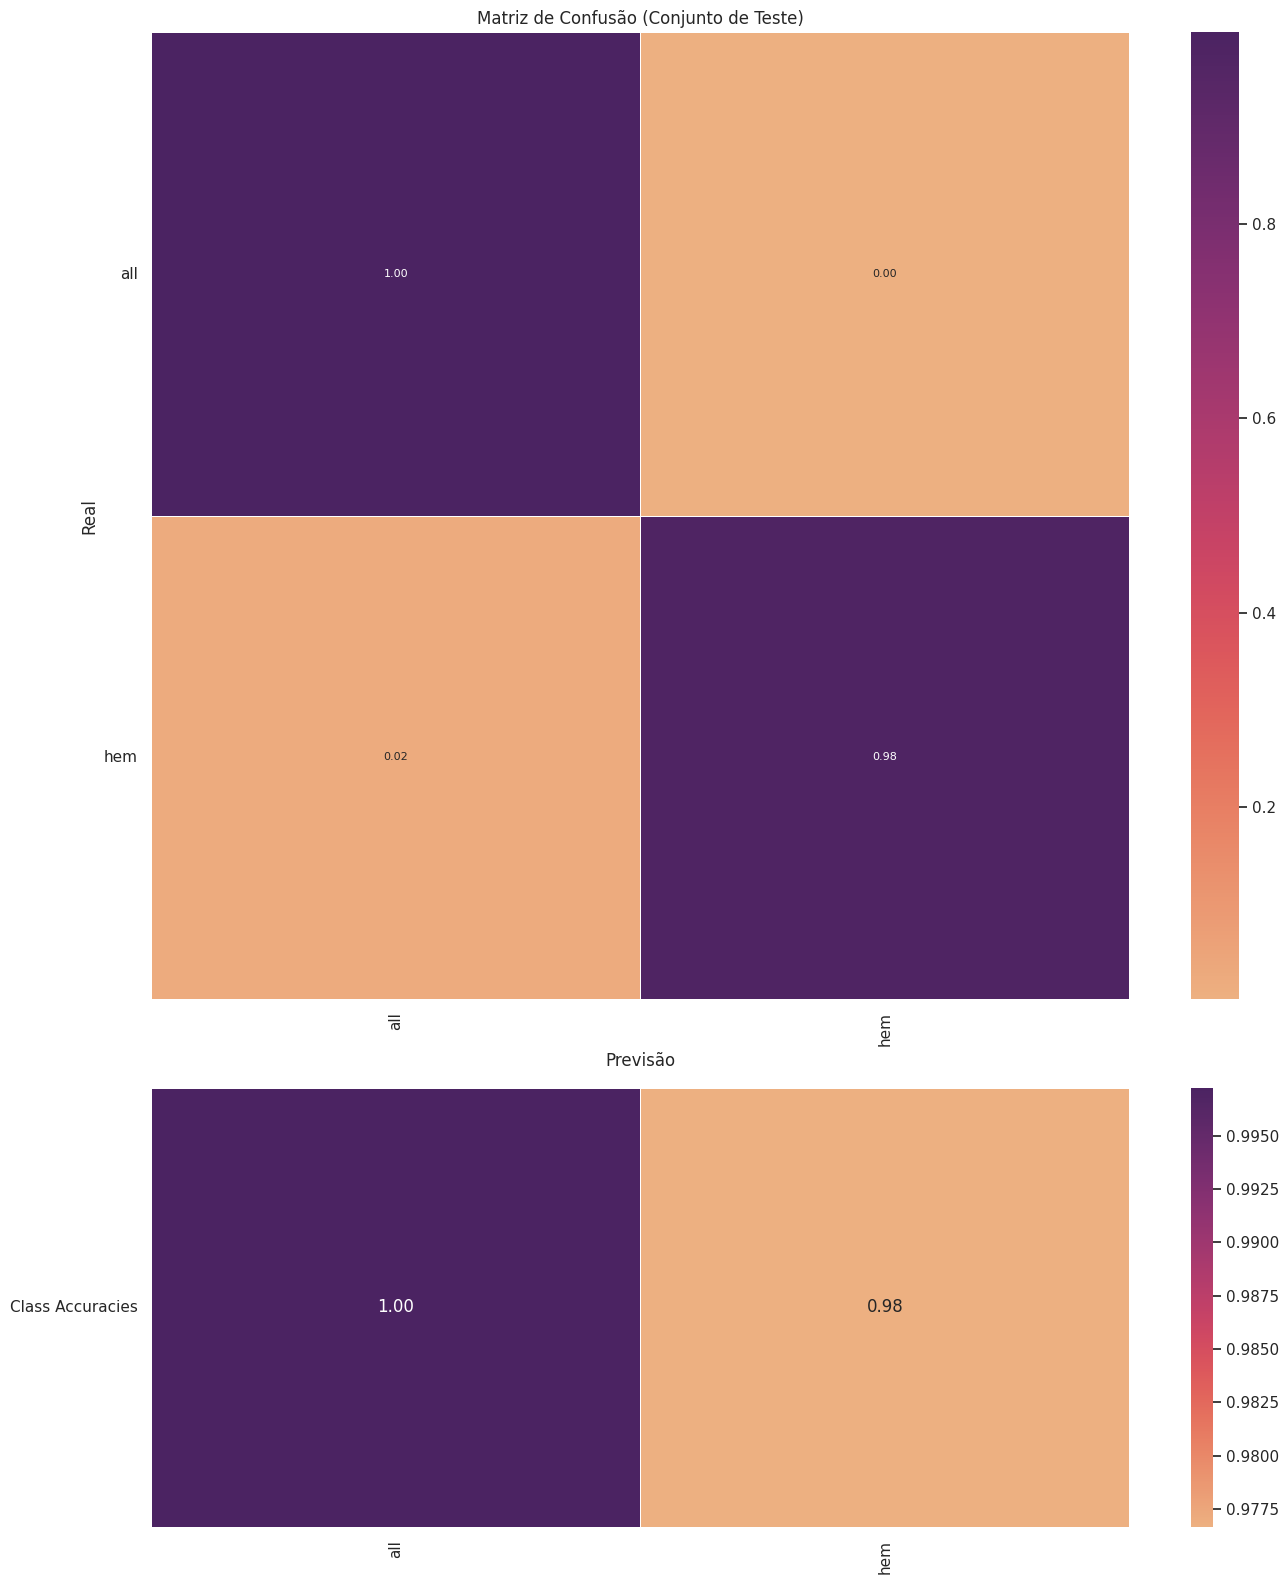

In [27]:
# --- Avaliação Final no Conjunto de Teste ---

print("Avaliando o modelo final no conjunto de teste...")

# 1. Reutilizar sua função _test_step_classification para calcular as métricas
#    A única mudança é passar o 'test_dataloader'
test_loss, test_accuracy, test_precision, test_recall, test_f1 = _test_step_classification(
    classifier_model,
    test_dataloader,
    criterion,
    device
)

print("\n--- Resultados Finais no Conjunto de Teste ---")
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')
print(f'Test F1: {test_f1:.4f}')

# 2. Gerar e plotar a Matriz de Confusão para o conjunto de teste
print("\nGerando a Matriz de Confusão...")
conf_matrix = get_conf_matrix(classifier_model, test_dataloader, device)

# Pegamos os nomes das classes a partir de um dos seus ImageFolder originais
class_names = fold_0.classes 

plot_confusion_matrix_with_diagonal(conf_matrix, labels=class_names, title_matrix='Matriz de Confusão (Conjunto de Teste)')

In [28]:
torch.save(classifier_model.state_dict(), 'parameters.pth')